# Modular Virus Simulation

## Activate Project

In [2]:
using Pkg
Pkg.activate("..")  # notebook is in a subdirectory
Pkg.status()

  Activating project at `~/LethalMutagenesis/production-model`


Status `~/LethalMutagenesis/production-model/Project.toml`
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.120
  [91a5bcdd] Plots v1.40.19
  [92933f4c] ProgressMeter v1.10.4
  [2913bbd2] StatsBase v0.34.6
  [bd369af6] Tables v1.12.1
  [b77e0a4c] InteractiveUtils v1.11.0
  [d6f4376e] Markdown v1.11.0
  [9a3f8284] Random v1.11.0


## Required libraries

In [3]:
using Markdown
using InteractiveUtils
using Random, Distributions, StatsBase, DataFrames, Plots
using CSV, Tables

## Constants and Parameters

### Fixed Parameters and Constants
Let's start with the physical constants that we are not seeking to change:

In [4]:
# Universal physical constants and fixed data
const kt_boltzmann = 0.001987204118 * (273.15 + 37)
const ΔΔG = Normal(1.0, 1.7)

Normal{Float64}(μ=1.0, σ=1.7)

And then let's set up the gene-level architecture. In this simulation we have assigned genes to four modules. In each module we imagine a different genetic/phenotypic architecture with implications for epistasis.

| Module Name | Architecture | Type of Epistasis | Variance Penalty |
|-------------|---------------------|-------------------|-------------|
| auxiliary | independent additive contributions | arithmetic mean | none |
| assembly | stoichiometric balance | geometric mean | moderate |
| replication | linear with rate limiting steps | minimum | high |
| host interaction | jointly necessary contributions | product | maximal |

The overall fitness is calculated as an equal-weighted product of the output from these modules resulting in a variance penalty at organism level and motivated by the idea that all modules are necessary (although some auxiliary genes might be more accurately described as non-essential under optimal conditions).

Now let's define these module sizes and characteristics:

In [5]:
Base.@kwdef struct EpistasisParams
    # Module configuration
    module_sizes::Dict{Symbol, Int} = Dict(
        :auxiliary => 3, 
        :assembly => 3, 
        :replication => 3, 
        :host_interaction => 3
    )
    
    # Calculated properties
    module_names::Vector{Symbol} = collect(keys(module_sizes))
    G::Int = sum(values(module_sizes)) # number_of_genes
end

# Constructor function (required to calculate G = number of genes)
function EpistasisParams(; module_sizes = Dict(:auxiliary => 3, :assembly => 3, :replication => 3, :host_interaction => 3),
                         module_names = collect(keys(module_sizes)))
    G = sum(values(module_sizes))
    return EpistasisParams(module_sizes, module_names, G)
end

EpistasisParams

In [6]:
# Instantiate with equal module sizes (the default)
equal_epi_config = EpistasisParams()

# Custom values reflecting phiX174 (unequal module sizes)
ΦX174_epi_config = EpistasisParams(
    module_sizes = Dict(
        :auxiliary => 2, # A* (blocks super-inf), K (optimises burst size) - overlaps, non-essential
        :assembly => 3, # B (internal scaffolding), D (external scaffolding), F (major capsid) - but H involved in stoichiometry
        :replication => 2, # A (rolling circle init), J (ssDNA binding)
        :host_interaction => 4 # C (DNA packaging), E (host cell lysis), G (major spike), H (DNA pilot/minor spike)
    )
)

# Custom values to remove epistasis and make everything a product
null_epi_config = EpistasisParams(
    module_sizes = Dict(
        :auxiliary => 1, 
        :assembly => 1, 
        :replication => 1, 
        :host_interaction => 8
    )
)

EpistasisParams(Dict(:replication => 1, :assembly => 1, :host_interaction => 8, :auxiliary => 1), [:replication, :assembly, :host_interaction, :auxiliary], 11)

### Variable Parameters
And now for the parameters that we can change in the simulation:

In [7]:
Base.@kwdef struct SimulationParams
    # Control parameters
    sim_length::Int = 500
    F_init::Float64 = -5.0
    # Sweep parameters
    U_default::Poisson = Poisson(5.0)
    L_default::Float64 = 0.1
    N_default::Int = 5000
    K_default::Int = 10000
    R_default::Int = 9
end

SimulationParams

In [8]:
sim_config = SimulationParams()  # All defaults
#sim_config = SimulationParams(L_default = 0.05, N_default = 2000)  # Custom values

SimulationParams(500, -5.0, Poisson{Float64}(λ=5.0), 0.1, 5000, 10000, 9)

## Defining the Virus

We represent the virus as a Julia Struct. It contains 2 dictionaries (where the keys are module names and the values are lists, one for each module). These dictionaries are for mutation counts (μ_counts) and for ΔG values (ΔG_values). We also see an atomic entry for fitness.

In [9]:
mutable struct ModularVirus
    μ_counts::Dict{Symbol, Vector{Int64}}
    ΔG_values::Dict{Symbol, Vector{Float64}}
    fitness::Float64
end

We have this convenience function for initializing a new modular virus and we preload our dictionaries with zero entries for mutation numbers and the initial value for free energy, while setting fitness to (nearly) 1:

In [10]:
# constructor for clean initialization
function ModularVirus(sim_config::SimulationParams, epi_config::EpistasisParams, start_fitness::Float64)
    μ_counts = Dict(name => zeros(Int64, epi_config.module_sizes[name]) for name in epi_config.module_names)
    ΔG_values = Dict(name => fill(sim_config.F_init, epi_config.module_sizes[name]) for name in epi_config.module_names)
    return ModularVirus(μ_counts, ΔG_values, start_fitness)
end

ModularVirus

### Testing
Create a test virus:

In [52]:
Quentin = ModularVirus(sim_config, equal_epi_config, 1.0)

ModularVirus(Dict(:replication => [0, 0, 0], :assembly => [0, 0, 0], :host_interaction => [0, 0, 0], :auxiliary => [0, 0, 0]), Dict(:replication => [-5.0, -5.0, -5.0], :assembly => [-5.0, -5.0, -5.0], :host_interaction => [-5.0, -5.0, -5.0], :auxiliary => [-5.0, -5.0, -5.0]), 1.0)

Force add a mutation:

In [53]:
for name in equal_epi_config.module_names
    Quentin.μ_counts[name][1] = 1
    Quentin.ΔG_values[name][1] = -0.4
end
Quentin

ModularVirus(Dict(:replication => [1, 0, 0], :assembly => [1, 0, 0], :host_interaction => [1, 0, 0], :auxiliary => [1, 0, 0]), Dict(:replication => [-0.4, -5.0, -5.0], :assembly => [-0.4, -5.0, -5.0], :host_interaction => [-0.4, -5.0, -5.0], :auxiliary => [-0.4, -5.0, -5.0]), 1.0)

## Epistasis and Fitness Calculations

Here we have functions for instantiating epistasis in different ways for each module:

In [11]:
function auxiliary_epistasis(auxiliary_ΔGs::Vector{Float64})
    # Additive contributions
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in auxiliary_ΔGs]
    # Arithmetic mean benefits from positives
    return mean(stabilities)
end

function assembly_epistasis(assembly_ΔGs::Vector{Float64})
    # Stoichiometric balance: variance in stabilities hurts fitness
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in assembly_ΔGs]
    # Geometric mean penalizes imbalance
    return prod(stabilities)^(1/length(stabilities))
end

function replication_epistasis(replication_ΔGs::Vector{Float64})
    # Rate-limiting: weakest link dominates
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in replication_ΔGs]
    return minimum(stabilities)
end

function host_module_epistasis(host_ΔGs::Vector{Float64})
    # Independent effects but negatives propagate
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in host_ΔGs]
    return prod(stabilities)
end

host_module_epistasis (generic function with 1 method)

Now we can generate a struct-modifying update fitness function:

In [12]:
function update_fitness!(virus::ModularVirus)
    auxiliary_contrib = auxiliary_epistasis(virus.ΔG_values[:auxiliary])
    assembly_contrib = assembly_epistasis(virus.ΔG_values[:assembly])
    replication_contrib = replication_epistasis(virus.ΔG_values[:replication])
    host_contrib = host_module_epistasis(virus.ΔG_values[:host_interaction])
    
    virus.fitness = auxiliary_contrib * assembly_contrib * replication_contrib * host_contrib
end

update_fitness! (generic function with 1 method)

### Testing
Try it and please do this carefully if zeroing out any module - the effects could be exotic:

In [56]:
println("Auxiliary: ", auxiliary_epistasis(Quentin.ΔG_values[:auxiliary]))
println("Assembly: ", assembly_epistasis(Quentin.ΔG_values[:assembly]))
println("Replication: ", replication_epistasis(Quentin.ΔG_values[:replication]))
println("Host Interaction: ", host_module_epistasis(Quentin.ΔG_values[:host_interaction]))

Auxiliary: 0.8853953603063478
Assembly: 0.8690692667366479
Replication: 0.6567854267448675
Host Interaction: 0.6563918441227488


In [57]:
update_fitness!(Quentin)

0.33172508788624777

In [58]:
Quentin.fitness

0.33172508788624777

## Making New Mutations

Enumerate and apply new mutations to a virus:

In [13]:
function mutate!(virus::ModularVirus, sim_config::SimulationParams, epi_config::EpistasisParams) 
    number_of_mutations = only(rand(sim_config.U_default, 1))
    ΔΔG_values = rand(ΔΔG, number_of_mutations)  # note that ΔΔG is a global
    
    # We choose modules proportionally to their size **and ordered by** module_names vector
    # care must be taken as keys(module_sizes) != module_names
    module_probs = Weights([epi_config.module_sizes[name] for name in epi_config.module_names] ./ epi_config.G)
    
    for i in 1:number_of_mutations
        # Select module based on proportional targeting
        module_choice = sample(epi_config.module_names, module_probs)
        
        # Select gene within module
        module_size = epi_config.module_sizes[module_choice]
        gene_index = rand(1:module_size)
        
        # Apply mutation to appropriate dictionary [and module therein][and gene]
        virus.μ_counts[module_choice][gene_index] += 1
        virus.ΔG_values[module_choice][gene_index] += ΔΔG_values[i]
        
        # Lethal mutation check
        if rand() < sim_config.L_default
            virus.fitness = 0
            return virus.fitness
        end
    end
    
    # Update fitness if virus is still viable
    (virus.fitness > 0) && (update_fitness!(virus))
    
    return virus.fitness
end

mutate! (generic function with 1 method)

## Reproduction

Here is a reproduction function:

In [14]:
# Creates new offspring virus by copying parent + its mutations
function reproduce(parent::ModularVirus, sim_config::SimulationParams, epi_config::EpistasisParams)
    sprog = deepcopy(parent)
    mutate!(sprog, sim_config, epi_config)
    return sprog
end

reproduce (generic function with 1 method)

## Creating a Population

Here is a convenience function to make a new population of viruses:

In [15]:
# Creates initial virus population
function initialize_population(sim_config::SimulationParams, epi_config::EpistasisParams)
    start_fitness = (1 / (1 + ℯ^(sim_config.F_init/kt_boltzmann)))^epi_config.G
    return [ModularVirus(sim_config, epi_config, start_fitness) for _ in 1:sim_config.N_default]
end

initialize_population (generic function with 1 method)

## Helper Functions

Here are some key helper functions that facilitate selection (get weights) or the selection of an integer number of offspring (probabilistic round):

In [16]:
# Used to implement fitness-proportional selection
function get_weights(populace)
    fitness_values = [v.fitness for v in populace]
    total = sum(fitness_values)
    fitness_values ./= total  # in-place division to avoid new array
    return Weights(fitness_values)
end

# Round a floating-point number to an integer
function probabilistic_round(number)
    base = floor(Int, number)
    return base + (rand() < number - base)
    # bracketed boolean expression evaluates to 0 or 1
end

# Helper function to get all ΔG values from a ModularVirus
function get_all_ΔG(virus::ModularVirus, epi_config::EpistasisParams)
    all_ΔG = Float64[]
    for module_name in epi_config.module_names
        append!(all_ΔG, virus.ΔG_values[module_name])
    end
    return all_ΔG
end

# Helper function to get all mutation counts from a ModularVirus  
function get_all_mutations(virus::ModularVirus, epi_config::EpistasisParams)
    return sum(sum(virus.μ_counts[module_name]) for module_name in epi_config.module_names)
end

# Helper function to get module-specific mean statistics
function get_module_stats(populace, module_name::Symbol)
    mut_counts = [sum(v.μ_counts[module_name]) for v in populace]
    ΔG_values = [mean(v.ΔG_values[module_name]) for v in populace]
    return mean(mut_counts), mean(ΔG_values)
end

get_module_stats (generic function with 1 method)

## Report and Plotting Functions

### Report Initialization and Filling Functions

Please note that the module names are hard-coded into these functions. Should the user choose an `epi_config` with different module names this function would need to be updated (or abstracted).

In [17]:
# Creates empty DataFrame with module-specific columns
function initialize_report()
    report = DataFrame(
        # Main metrics
        generation = Int[],
        psiz = Int[], 
        q1fit = Union{Float64, Missing}[], 
        meanfit = Union{Float64, Missing}[],
        q2fit = Union{Float64, Missing}[], 
        maxfit = Union{Float64, Missing}[], 
        minfree = Union{Float64, Missing}[],
        meanfree = Union{Float64, Missing}[], 
        maxfree = Union{Float64, Missing}[], 
        minmut = Union{Float64, Missing}[],
        meanmut = Union{Float64, Missing}[], 
        maxmut = Union{Float64, Missing}[],
        # Module-specific mutation counts
        auxiliary_meanmut = Union{Float64, Missing}[],
        assembly_meanmut = Union{Float64, Missing}[],
        replication_meanmut = Union{Float64, Missing}[],
        host_meanmut = Union{Float64, Missing}[],
        # Module-specific free energies  
        auxiliary_meanfree = Union{Float64, Missing}[],
        assembly_meanfree = Union{Float64, Missing}[],
        replication_meanfree = Union{Float64, Missing}[],
        host_meanfree = Union{Float64, Missing}[]
    )
    return report
end

# Updates DataFrame with both original and module-specific metrics
function report_update!(populace, report, epi_config::EpistasisParams, generation::Int)

    if isempty(populace)
        # Handle extinction case - population size is 0, everything else is missing
        push!(report, (
            generation = generation,
            psiz = 0,  # Population size is 0
            q1fit = missing,
            meanfit = missing,
            q2fit = missing,
            maxfit = missing,
            minfree = missing,
            meanfree = missing,
            maxfree = missing,
            minmut = missing,
            meanmut = missing,
            maxmut = missing,
            auxiliary_meanmut = missing,
            assembly_meanmut = missing,
            replication_meanmut = missing,
            host_meanmut = missing,
            auxiliary_meanfree = missing,
            assembly_meanfree = missing,
            replication_meanfree = missing,
            host_meanfree = missing
        ))
        return
    end

    # Original metrics
    fitness_values = [v.fitness for v in populace]
    all_ΔG_per_virus = [get_all_ΔG(v, epi_config) for v in populace]
    all_mutations_per_virus = [get_all_mutations(v, epi_config) for v in populace]
    
    # Module-specific metrics
    aux_mut, aux_free = get_module_stats(populace, :auxiliary)
    asm_mut, asm_free = get_module_stats(populace, :assembly)
    rep_mut, rep_free = get_module_stats(populace, :replication)
    host_mut, host_free = get_module_stats(populace, :host_interaction)
    
    # Precompute ΔG statistics for efficiency
    ΔG_mins = [minimum(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    ΔG_means = [mean(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    ΔG_maxs = [maximum(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    
    push!(report, (
        generation = generation,
        psiz = length(populace),
        q1fit = quantile(fitness_values, 0.25),
        meanfit = mean(fitness_values),
        q2fit = median(fitness_values),
        maxfit = maximum(fitness_values),
        minfree = mean(ΔG_mins),
        meanfree = mean(ΔG_means),
        maxfree = mean(ΔG_maxs),
        minmut = minimum(all_mutations_per_virus),
        meanmut = mean(all_mutations_per_virus),
        maxmut = maximum(all_mutations_per_virus),
        auxiliary_meanmut = aux_mut,
        assembly_meanmut = asm_mut,
        replication_meanmut = rep_mut,
        host_meanmut = host_mut,
        auxiliary_meanfree = aux_free,
        assembly_meanfree = asm_free,
        replication_meanfree = rep_free,
        host_meanfree = host_free
    ))
end

report_update! (generic function with 1 method)

### Plotting Function

In [18]:
#creates plots including module-specific panels
function plot_simulation(report)
    abscissa = 1:size(report, 1)
    
    p1 = plot(abscissa, report.psiz, 
        ylims = (0, maximum(report.psiz)),
        label = "pop size", linewidth = 3, title = "A) Population Size")
        
    p2 = plot(abscissa, [report.q1fit report.meanfit report.q2fit report.maxfit],
        label = ["Q1 fitness" "mean fitness" "median fitness" "max fitness"], 
        linewidth = 3, title = "B) Fitness Distribution")
        
    p3 = plot(abscissa, [report.minfree report.meanfree report.maxfree],
        label = ["min ΔG" "mean ΔG" "max ΔG"],
        linewidth = 3, title = "C) Free Energy Distribution")
        
    p4 = plot(abscissa, [report.minmut report.meanmut report.maxmut],
        label = ["min mutations" "mean mutations" "max mutations"],
        linewidth = 3, title = "D) Total Mutations")
        
    p5 = plot(abscissa, [report.replication_meanmut report.assembly_meanmut report.host_meanmut],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "E) Mutations by Module")
        
    p6 = plot(abscissa, [report.replication_meanfree report.assembly_meanfree report.host_meanfree],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "F) Mean ΔG by Module")
    
    plot(p1, p2, p3, p4, p5, p6, 
        titleloc = :left, 
        titlefont = font(12), 
        layout = (3, 2), 
        size = (1000, 1000))
end

plot_simulation (generic function with 1 method)

## Simulation Proper

Let's start with a function to replicate the next generation:

In [19]:
# Simulates one generation of the population. fitness pushed to next generation
function synchronized_generation(populace, sim_config::SimulationParams, epi_config::EpistasisParams) 
    next_generation = ModularVirus[]
    # equivalent to Array{ModularVirus,1}() and eliminates type checking later
    
    for parent in populace
        offspring_count = probabilistic_round(sim_config.R_default * parent.fitness)
        for r in 1:offspring_count
            child = reproduce(parent, sim_config, epi_config)
            # Only add viable offspring (short-circuit evaluation)
            (child.fitness > 0) && push!(next_generation, child)
        end
    end
    
    return next_generation
end

synchronized_generation (generic function with 1 method)

Now let's generate a function that yields a complete simulation:

In [20]:
# Runs main sim and collects data into DataFrame
function synchronized_simulation(sim_config::SimulationParams, epi_config::EpistasisParams; 
                                report_frequency = 20)
    # Initialize population and reporting
    population = initialize_population(sim_config, epi_config)
    report = initialize_report()
    
    generation = 0
    max_generations = sim_config.sim_length
    
    while generation < max_generations
        generation += 1
        
        # Progress reporting
        if generation % report_frequency == 0
            println("Generation: $generation, Population size: $(length(population))")
        end
        
        # Collect data before selection/reproduction
        report_update!(population, report, epi_config, generation)
        
        # Generate next generation
        population = synchronized_generation(population, sim_config, epi_config)
        population_size = length(population)
        
        # Apply carrying capacity constraint
        if population_size > sim_config.K_default
            population = sample(population, sim_config.K_default, replace = false)
        elseif population_size == 0
            println("Population extinct at generation $generation")
            report_update!([], report, epi_config, generation)
            break
        end
    end
    
    # Final report update if simulation completed
    if length(population) > 0
        report_update!(population, report, epi_config, generation)
    end
    
    return report, population
end

synchronized_simulation (generic function with 1 method)

In [21]:
# Convenience function with default parameters
function run_simulation(; sim_config = SimulationParams(), epi_config = EpistasisParams(),
                        report_frequency = 20)
    return synchronized_simulation(sim_config, epi_config; report_frequency = report_frequency)
end

run_simulation (generic function with 1 method)

# Run the Simulation

Please uncomment if you wish to run (commented to focus on parameter sweep below):

In [68]:
#=
# All defaults
report, pop = run_simulation()

# Plot the results
plot_simulation(report)
=#

Generation: 20, Population size: 9766
Generation: 40, Population size: 5212
Generation: 60, Population size: 6045
Generation: 80, Population size: 10000
Generation: 100, Population size: 10000
Generation: 120, Population size: 8486
Generation: 140, Population size: 4952
Generation: 160, Population size: 10000
Generation: 180, Population size: 10000
Generation: 200, Population size: 7308
Generation: 220, Population size: 5397
Generation: 240, Population size: 7854
Generation: 260, Population size: 10000
Generation: 280, Population size: 10000
Generation: 300, Population size: 10000
Generation: 320, Population size: 10000
Generation: 340, Population size: 10000
Generation: 360, Population size: 10000
Generation: 380, Population size: 9064
Generation: 400, Population size: 3988


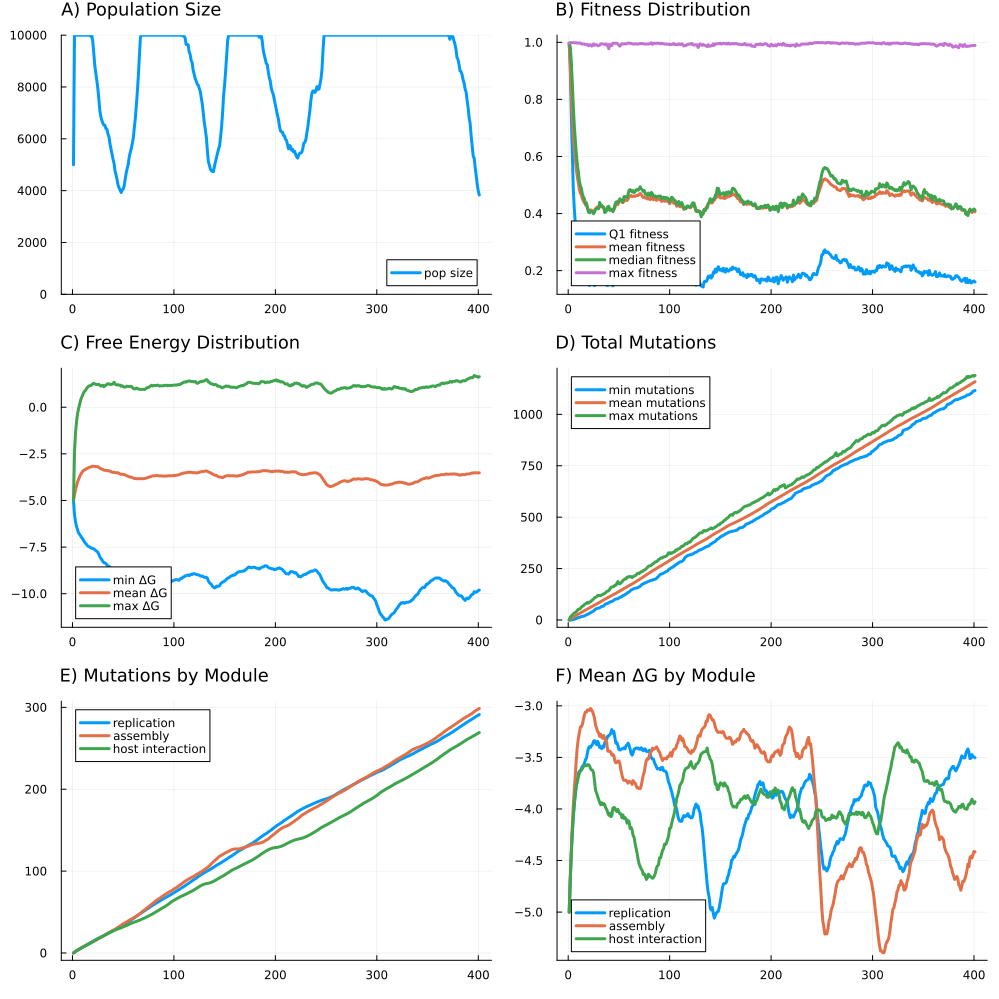

In [69]:
# Custom configs
custom_sim = SimulationParams(L_default = 0.27, sim_length = 400)
report, pop = run_simulation(sim_config = custom_sim, epi_config = equal_epi_config)

# Plot the results
plot_simulation(report)

In [70]:
#report

In [71]:
#=
# Another example with custom parameters
custom_sim = SimulationParams(L_default = 0.02, R_default = 10, N_default = 2000, K_default = 4000, sim_length = 200)
report, pop = run_simulation(sim_config = custom_sim, epi_config = ΦX174_epi_config, report_frequency = 10)

# Plot the results
plot_simulation(report)
=#

# Parameter Sweeps

This is working parameter sweep code:

In [22]:
function run_parameter_sweep(base_dir::String, epi_config::EpistasisParams; 
                           num_reps = 5,
                           R_range = 0:2:10,
                           U_range = 0:0.5:5.0, 
                           L_range = 0.0:0.2:1.0)
    
    mkpath(base_dir)
    
    # Create master results DataFrame for aggregation
    all_results = DataFrame()
    
    for R in R_range
        for U in U_range
            for L in L_range
                
                # Create parameter-specific directory
                param_dir = joinpath(base_dir, "R$(R)_U$(U)_L$(L)")
                mkpath(param_dir)
                
                println("Running parameter combination: R=$R, U=$U, L=$L")
                
                for rep in 1:num_reps
                    # Generate unique seed for this replicate
                    seed = rand(Int)
                    
                    # Create simulation config with current parameters
                    sweep_sim_config = SimulationParams(
                        R_default = R,
                        U_default = Poisson(U),
                        L_default = L
                    )
                    
                    # Run simulation
                    Random.seed!(seed)
                    report, final_pop = synchronized_simulation(sweep_sim_config, epi_config; report_frequency = 999999)

                    # Add metadata to report
                    # Insert multiple columns at the beginning
                    insertcols!(report, 1, 
                        :R => R,
                        :U => U, 
                        :L => L,
                        :N => sweep_sim_config.N_default,
                        :K => sweep_sim_config.K_default,
                        :replicate => rep,
                        :seed => seed
                    )
                    
                    # Save individual replicate files
                    csv_filename = joinpath(param_dir, "rep$(rep)_seed$(seed).csv")
                    png_filename = joinpath(param_dir, "rep$(rep)_seed$(seed).png")
                    
                    CSV.write(csv_filename, report)
                    
                    # Save plot
                    p = plot_simulation(report)
                    savefig(p, png_filename)
                    
                    # Add to master dataset
                    append!(all_results, report)
                    
                    println("  Completed replicate $rep (seed: $seed)")
                end
            end
        end
    end
    
    # Save master results
    master_csv = joinpath(base_dir, "master_results.csv")
    CSV.write(master_csv, all_results)
    
    println("Parameter sweep complete. Master results saved to: $master_csv")
    return all_results
end

run_parameter_sweep (generic function with 1 method)

Here's the code to run with a full, serially executed parameter sweep but not the code is commented out for now because I'd like to create a parallel execution option for efficiency:

In [73]:
#results = run_parameter_sweep("simulation_results", ΦX174_epi_config; num_reps = 3)

# Parameter Sweeps with Parallel Execution

Let's start with some system checks:

In Julia REPL do this before running this notebook:
```
using IJulia
IJulia.installkernel("Julia 8 threads", env=Dict("JULIA_NUM_THREADS"=>"8"))
```
And make sure to select the appropriate kernel to run this notebook.

Note I have a 12 thread machine (M2 Pro), but I am also experimenting with 16 threads on my M1 Ultra.

In [23]:
# Check what you actually got:
println("Threads: ", Threads.nthreads())

Threads: 24


In [24]:
# Before running, check available memory
println("Memory info: ")
println(Sys.total_memory() / 1e9, " GB total")
println(Sys.free_memory() / 1e9, " GB free")

Memory info: 
540.404637696 GB total
532.803956736 GB free


In [25]:
using Base.Threads
using ProgressMeter # making progress bar version - in progress

function run_parameter_sweep_parallel(base_dir::String, epi_config::EpistasisParams; 
                                    num_reps = 5,
                                    R_range = 0:2:10,
                                    U_range = 0:0.5:5.0, 
                                    L_range = 0.0:0.2:1.0)
    
    mkpath(base_dir)
    
    # Pre-generate all parameter combinations and seeds
    param_combinations = []
    for R in R_range, U in U_range, L in L_range, rep in 1:num_reps
        seed = rand(Int)
        push!(param_combinations, (R=R, U=U, L=L, rep=rep, seed=seed))
    end

    total_sims = length(param_combinations)
    println("Running $total_sims simulations on $(nthreads()) threads...")
    
    # Thread-safe storage for results
    all_results = Vector{DataFrame}(undef, total_sims)

    # Create progress bar
    progress = Progress(total_sims, desc="Simulations: ", barlen=50, color=:green)
    
    # Parallel execution
    @threads for i in 1:total_sims
        params = param_combinations[i]
        
        # Create parameter-specific directory (thread-safe)
        param_dir = joinpath(base_dir, "R$(params.R)_U$(params.U)_L$(params.L)")
        mkpath(param_dir)
        
        # Create simulation config
        sweep_sim_config = SimulationParams(
            R_default = params.R,
            U_default = Poisson(params.U),
            L_default = params.L
        )
        
        # Set seed for this specific simulation
        Random.seed!(params.seed)
        
        # Run simulation
        report, final_pop = synchronized_simulation(sweep_sim_config, epi_config; report_frequency = 999999)
        
        # Add metadata
        insertcols!(report, 1, 
            :R => params.R,
            :U => params.U, 
            :L => params.L,
            :N => sim_config.N_default,
            :K => sim_config.K_default,
            :replicate => params.rep,
            :seed => params.seed
        )
        
        # Save CSV file
        csv_filename = joinpath(param_dir, "rep$(params.rep)_seed$(params.seed).csv")        
        CSV.write(csv_filename, report)
        
        # Store result for later aggregation
        all_results[i] = report
        
        # Update progress bar (thread-safe)
        next!(progress)
        #println("Completed: R=$(params.R), U=$(params.U), L=$(params.L), rep=$(params.rep) on thread $(threadid())")
    end
    
    # Combine all results
    master_results = vcat(all_results...)
    
    # Save master results
    master_csv = joinpath(base_dir, "master_results.csv")

    if isfile(master_csv)
        # Append to existing file
        CSV.write(master_csv, master_results, append=true, header=false)
        println("\nParameter sweep complete! Results appended to existing: $master_csv")
        println("Added $(nrow(master_results)) new rows to master file")
    else
        # Create new file
        CSV.write(master_csv, master_results)
        println("\nParameter sweep complete! New master results saved to: $master_csv")
        println("Created master file with $(nrow(master_results)) rows")
    end
    
    return master_results
end

run_parameter_sweep_parallel (generic function with 1 method)

Note that I've had to comment out the plot generation as this appeared not to be safe in parallel execution.

Now run parameter sweep!

In [77]:
#results = run_parameter_sweep_parallel("simulation_results", ΦX174_epi_config; num_reps = 3)

# Try a small test with 8 threads
results = run_parameter_sweep_parallel("test_run", ΦX174_epi_config; 
                                      num_reps = 1,
                                      R_range = [1, 10],      # 2 values
                                      U_range = [1.0, 5.0],   # 2 values  
                                      L_range = [0.0])        # 1 value

Running 4 simulations on 24 threads...
Population extinct at generation 13
Population extinct at generation 50


Simulations: 100%|██████████████████████████████████████████████████| Time: 0:03:36



Parameter sweep complete! Results appended to existing: test_run/master_results.csv
Added 1067 new rows to master file


Row,R,U,L,N,K,replicate,seed,generation,psiz,q1fit,meanfit,q2fit,maxfit,minfree,meanfree,maxfree,minmut,meanmut,maxmut,auxiliary_meanmut,assembly_meanmut,replication_meanmut,host_meanmut,auxiliary_meanfree,assembly_meanfree,replication_meanfree,host_meanfree
,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,1,1.0,0.0,5000,10000,1,3962908952543578658,1,5000,0.996709,0.996709,0.996709,0.996709,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-5.0,-5.0,-5.0
2,1,1.0,0.0,5000,10000,1,3962908952543578658,2,4988,0.993129,0.976982,0.997904,0.998549,-5.26372,-4.91196,-3.95257,0.0,0.989174,7.0,0.179631,0.264836,0.183841,0.360866,-4.91508,-4.90741,-4.91245,-4.91355
3,1,1.0,0.0,5000,10000,1,3962908952543578658,3,4885,0.97549,0.955544,0.995237,0.998598,-5.48518,-4.82703,-3.25938,0.0,1.97769,8.0,0.3652,0.526714,0.357421,0.728352,-4.82397,-4.82195,-4.83459,-4.82857
4,1,1.0,0.0,5000,10000,1,3962908952543578658,4,4656,0.955181,0.938293,0.990171,0.9987,-5.66052,-4.75322,-2.79999,0.0,2.95747,11.0,0.537801,0.814648,0.526632,1.07839,-4.75311,-4.7396,-4.75992,-4.76015
5,1,1.0,0.0,5000,10000,1,3962908952543578658,5,4364,0.934671,0.924781,0.983025,0.998756,-5.81753,-4.68483,-2.46025,0.0,3.92851,14.0,0.716315,1.09303,0.701421,1.41774,-4.67774,-4.65766,-4.69708,-4.70263
6,1,1.0,0.0,5000,10000,1,3962908952543578658,6,4031,0.914142,0.910427,0.975732,0.99867,-5.92695,-4.61902,-2.21182,0.0,4.84594,14.0,0.896304,1.34384,0.860332,1.74547,-4.59913,-4.59267,-4.62962,-4.64344
7,1,1.0,0.0,5000,10000,1,3962908952543578658,7,3686,0.891354,0.897953,0.967143,0.99867,-6.04819,-4.56434,-2.02404,0.0,5.74281,15.0,1.05236,1.6115,1.02035,2.0586,-4.54551,-4.53555,-4.56644,-4.59431
8,1,1.0,0.0,5000,10000,1,3962908952543578658,8,3331,0.864601,0.884107,0.959862,0.998763,-6.13132,-4.50414,-1.87042,0.0,6.66677,18.0,1.22246,1.8598,1.19604,2.38847,-4.48442,-4.47399,-4.48581,-4.54576
9,1,1.0,0.0,5000,10000,1,3962908952543578658,9,2936,0.860327,0.879855,0.954657,0.998593,-6.22866,-4.46749,-1.78991,1.0,7.47377,22.0,1.36649,2.07425,1.36069,2.67234,-4.45089,-4.42595,-4.44205,-4.51966


Now let's try a medium-sized test:

In [78]:
#=
results = run_parameter_sweep_parallel("medium_test", ΦX174_epi_config; 
                                      num_reps = 2,
                                      R_range = 0:5:10,      # 3 values  
                                      U_range = 0:2.5:5.0,   # 3 values
                                      L_range = 0.0:0.5:1.0) # 3 values
=#

Here's the full sweep (not yet run):

In [79]:
#=
results = run_parameter_sweep_parallel("full_sweep", ΦX174_epi_config; 
                                      num_reps = 5,
                                      R_range = 0:2:10,
                                      U_range = 0:0.5:5.0, 
                                      L_range = 0.0:0.2:1.0)
=#

## Regenerating Graphs

This we will do in serial after the parallel simulation code:

In [ ]:
function generate_missing_plots(base_dir::String; file_pattern = r"rep\d+_seed-?\d+\.csv$")
    plot_count = 0
    skipped_count = 0
    
    println("Scanning directory: $base_dir")
    
    for (root, dirs, files) in walkdir(base_dir)
        println("Checking directory: $root")
        for file in files
            if occursin(file_pattern, file) && endswith(file, ".csv")
                csv_path = joinpath(root, file)
                png_path = replace(csv_path, ".csv" => ".png")

                println("  Found CSV: $file")
                println("  PNG would be: $(basename(png_path))")
                println("  PNG exists? $(isfile(png_path))")
                
                # Only generate if PNG doesn't exist
                if !isfile(png_path)
                    try
                        println("Generating plot for: $(basename(csv_path))")
                        report = CSV.read(csv_path, DataFrame)
                        p = plot_simulation(report)
                        savefig(p, png_path)
                        plot_count += 1
                    catch e
                        println("Error plotting $csv_path: $e")
                    end
                else
                    skipped_count += 1
                end
            end
        end
    end
    
    println("\nPlot generation complete!")
    println("Generated: $plot_count new plots")
    println("Skipped: $skipped_count existing plots")
end

generate_missing_plots (generic function with 1 method)

In [ ]:
# Generate plots for small test run
generate_missing_plots("test_run")

# Specific folder
#generate_missing_plots("../scripts/parameter_sweep_results")

# Or specify custom pattern if needed
#generate_missing_plots("../scripts/parameter_sweep_results", file_pattern = r"rep\d+_seed\d+\.csv$") # positive seeds only

Scanning directory: ../scripts/parameter_sweep_results
Checking directory: ../scripts/parameter_sweep_results
Checking directory: ../scripts/parameter_sweep_results/R0_U0.0_L0.0
  Found CSV: rep1_seed-7560493421792025401.csv
  PNG would be: rep1_seed-7560493421792025401.png
  PNG exists? false
Generating plot for: rep1_seed-7560493421792025401.csv
  Found CSV: rep2_seed4662274391607836890.csv
  PNG would be: rep2_seed4662274391607836890.png
  PNG exists? true
  Found CSV: rep3_seed8764381840429449068.csv
  PNG would be: rep3_seed8764381840429449068.png
  PNG exists? true
  Found CSV: rep4_seed6322532562107800614.csv
  PNG would be: rep4_seed6322532562107800614.png
  PNG exists? true
  Found CSV: rep5_seed-2109647260887221765.csv
  PNG would be: rep5_seed-2109647260887221765.png
  PNG exists? false
Generating plot for: rep5_seed-2109647260887221765.csv
Checking directory: ../scripts/parameter_sweep_results/R0_U0.0_L0.2
  Found CSV: rep1_seed-3373483902284764598.csv
  PNG would be: rep1_

## Calculate Extinction Generations

Here is a function to calculate the generation at which each simulation goes extinct:

In [30]:
# Method overloading

# Method with just the master CSV path
function detect_extinctions(master_csv_path::String)
    output_path = replace(master_csv_path, ".csv" => "_extinctions.csv")
    return detect_extinctions(master_csv_path, output_path)
end

# Method with both paths specified
function detect_extinctions(master_csv_path::String, output_path::String)
    # Load master results
    master_results = CSV.read(master_csv_path, DataFrame)
    
    # Group by simulation parameters and replicate
    grouping_cols = [:R, :U, :L, :N, :K, :replicate, :seed]

    # Pre-define DataFrame with correct column types
    extinction_results = DataFrame(
        R = Int64[],
        U = Float64[],
        L = Float64[],
        N = Int64[],
        K = Int64[],
        replicate = Int64[],
        seed = Int64[],
        extinction_generation = Union{Int64, Missing}[],  # Allow missing
        extinction_status = String[],
        final_generation = Int64[],
        final_popsize = Int64[]
    )
        
    for group_df in groupby(master_results, grouping_cols)
        # Get the simulation parameters (same for all rows in this group)
        sim_params_row = group_df[1, grouping_cols]
        
        # Find extinction: first generation where population size = 0
        extinct_row = findfirst(row -> row.psiz == 0, eachrow(group_df))
        
        if extinct_row !== nothing
            extinction_generation = group_df[extinct_row, :generation]
            extinction_status = "extinct"
        else
            extinction_generation = missing
            extinction_status = "survived"
        end
        
        # Create new row as a NamedTuple (or use push! with individual values)
        result_row = (
            R = sim_params_row.R,
            U = sim_params_row.U,
            L = sim_params_row.L,
            N = sim_params_row.N,
            K = sim_params_row.K,
            replicate = sim_params_row.replicate,
            seed = sim_params_row.seed,
            extinction_generation = extinction_generation,
            extinction_status = extinction_status,
            final_generation = maximum(group_df.generation),
            final_popsize = group_df[end, :psiz]
        )
        
        push!(extinction_results, result_row)
    end
    
    # Write to file
    CSV.write(output_path, extinction_results)
    println("Extinction analysis saved to: $output_path")
    
    # Print summary
    survival_summary = combine(groupby(extinction_results, :extinction_status), nrow => :count)
    println("Survival summary:")
    println(survival_summary)
    
    return output_path
end

detect_extinctions (generic function with 2 methods)

In [32]:
# Analyze extinctions and save results
#detect_extinctions("test_run/master_results.csv")
# Creates: test_run/master_results_extinctions.csv

detect_extinctions("../scripts/parameter_sweep_results/master_results.csv")
# Or specify custom output path
#detect_extinctions("../scripts/parameter_sweep_results", "extinction_analysis.csv")

Extinction analysis saved to: ../scripts/parameter_sweep_results/master_results_extinctions.csv
Survival summary:
2×2 DataFrame
 Row │ extinction_status  count 
     │ String             Int64 
─────┼──────────────────────────
   1 │ extinct             1015
   2 │ survived             965


"../scripts/parameter_sweep_results/master_results_extinctions.csv"

I note that R2_U3.0_L0.0 seems to have a lot of variation in results.

## Survival Graphs
Let's try to graph the survival data:

In [103]:
using CSV, DataFrames, Plots
using Statistics

"""
    prepare_contour_data(filepath::String, L_value::Float64)

Load extinction data and prepare it for a specific L value, aggregating replicates if necessary.
Returns grids suitable for contour plotting.
"""
function prepare_contour_data(filepath::String, L_value::Float64)
    # Read the CSV data
    df = CSV.read(filepath, DataFrame)

    # Filter for specific L value
    subset_df = filter(row -> row.L == L_value, df)

    if nrow(subset_df) == 0
        @warn "No data found for L = $L_value"
        return nothing
    end

    # Group by R, U and calculate statistics across replicates
    grouped = combine(groupby(subset_df, [:R, :U]),
        :final_generation => mean => :mean_extinction_gen,
        :final_generation => std => :std_extinction_gen,
        :extinction_status => (x -> mean(x .== "extinct")) => :extinction_rate,
        nrow => :n_replicates)

    # Get unique values for grid
    R_vals = sort(unique(grouped.R))
    U_vals = sort(unique(grouped.U))

    # Create matrices for contour plotting
    Z_mean = zeros(length(R_vals), length(U_vals))
    Z_extinction_rate = zeros(length(R_vals), length(U_vals))

    for (i, r) in enumerate(R_vals)
        for (j, u) in enumerate(U_vals)
            idx = findfirst((grouped.R .== r) .& (grouped.U .== u))
            if idx !== nothing
                Z_mean[i, j] = grouped.mean_extinction_gen[idx]
                Z_extinction_rate[i, j] = grouped.extinction_rate[idx]
            else
                Z_mean[i, j] = NaN
                Z_extinction_rate[i, j] = NaN
            end
        end
    end

    return (R_vals=R_vals, U_vals=U_vals, Z_mean=Z_mean, Z_extinction_rate=Z_extinction_rate, data=grouped)
end

"""
    create_contour_plot(contour_data, L_value::Float64; plot_type::Symbol=:extinction_generation)

Create a contour plot for a specific L value.
plot_type can be :extinction_generation or :extinction_rate
"""
function create_contour_plot(contour_data, L_value::Float64; plot_type::Symbol=:extinction_generation)
    if contour_data === nothing
        return plot(title="No data for L = $L_value")
    end

    R_vals, U_vals, Z_mean, Z_extinction_rate = contour_data.R_vals, contour_data.U_vals,
    contour_data.Z_mean, contour_data.Z_extinction_rate

    if plot_type == :extinction_generation
        Z_plot = Z_mean
        title_str = "L = $L_value"
        color_scheme = :viridis
        cb_label = "Generation"
    elseif plot_type == :extinction_rate
        Z_plot = Z_extinction_rate
        title_str = "L = $L_value"
        color_scheme = :reds
        cb_label = "Extinction Rate"
    else
        error("plot_type must be :extinction_generation or :extinction_rate")
    end

    # Create the contour plot
    p = contour(U_vals, R_vals, Z_plot,
        xlabel="U",
        ylabel="R",
        title=title_str,
        colorbar_title=cb_label,
        c=color_scheme,
        fill=true,
        linewidth=0.5,
        levels=15,
        top_margin=4Plots.mm,
        bottom_margin=5Plots.mm,
        left_margin=2Plots.mm,
        right_margin=8Plots.mm)

    # Add scatter points to show actual data locations
    # Color markers red if ≥50% of replicates went extinct
    marker_colors = [rate >= 0.5 ? :red : :white for rate in contour_data.data.extinction_rate]

    scatter!(p,
        [contour_data.data.U],
        [contour_data.data.R],
        markersize=4,
        markercolor=marker_colors,
        markerstrokecolor=:black,
        markerstrokewidth=0.5,
        alpha=0.8,
        label="")

    return p
end

"""
    create_all_contour_plots(filepath::String; plot_type::Symbol=:extinction_generation)

Create contour plots for all unique L values in the dataset.
"""
function create_all_contour_plots(filepath::String; plot_type::Symbol=:extinction_generation)
    # Load data to get unique L values
    df = CSV.read(filepath, DataFrame)
    L_values = sort(unique(df.L))
    plots_array = []

    for L_val in L_values
        contour_data = prepare_contour_data(filepath, L_val)
        p = create_contour_plot(contour_data, L_val; plot_type=plot_type)
        push!(plots_array, p)
    end

    # Arrange plots in a grid with overall title
    n_plots = length(plots_array)

    # Determine overall title based on plot type
    if plot_type == :extinction_generation
        overall_title = "Mean Extinction/Final Generation"
    else
        overall_title = "Extinction Rate"
    end

    if n_plots == 1
        return plot(plots_array[1], plot_title=overall_title, size=(600, 800))
    elseif n_plots <= 4
        return plot(plots_array..., layout=(2, 2), size=(1200, 700), plot_title=overall_title)
    else
        # For more than 4 plots, arrange in rows of 3
        n_rows = ceil(Int, n_plots / 3)
        return plot(plots_array..., layout=(n_rows, 3), size=(1600, 400 * n_rows), plot_title=overall_title)
    end
end

"""
    analyze_extinction_patterns(filepath::String)

Complete analysis pipeline for extinction data.
"""
function analyze_extinction_patterns(filepath::String)
    println("Loading extinction data...")
    df = CSV.read(filepath, DataFrame)

    println("Data summary:")
    println("Unique R values: ", sort(unique(df.R)))
    println("Unique U values: ", sort(unique(df.U)))
    println("Unique L values: ", sort(unique(df.L)))
    println("Total observations: ", nrow(df))
    println("Extinction rate: ", round(mean(df.extinction_status .== "extinct"), digits=3))

    # Create extinction generation plots
    println("\nCreating extinction generation contour plots...")
    p1 = create_all_contour_plots(filepath; plot_type=:extinction_generation)

    # Create extinction rate plots
    println("Creating extinction rate contour plots...")
    p2 = create_all_contour_plots(filepath; plot_type=:extinction_rate)

    return (generation_plots=p1, extinction_rate_plots=p2, data=df)
end

analyze_extinction_patterns

Loading extinction data...
Data summary:
Unique R values: [0, 2, 4, 6, 8, 10]
Unique U values: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Unique L values: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Total observations: 1980
Extinction rate: 0.513

Creating extinction generation contour plots...
Creating extinction rate contour plots...


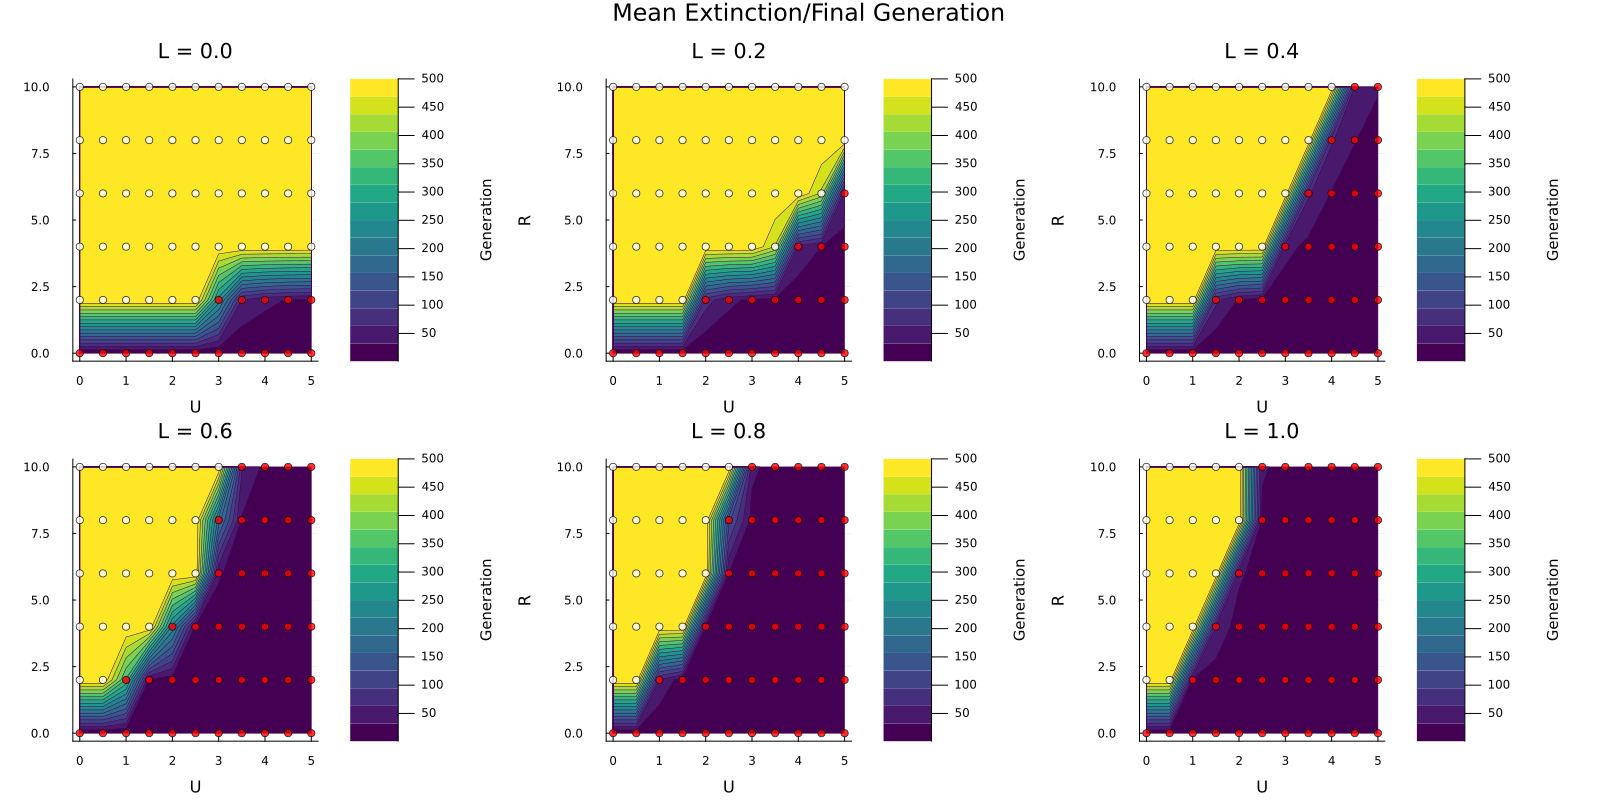

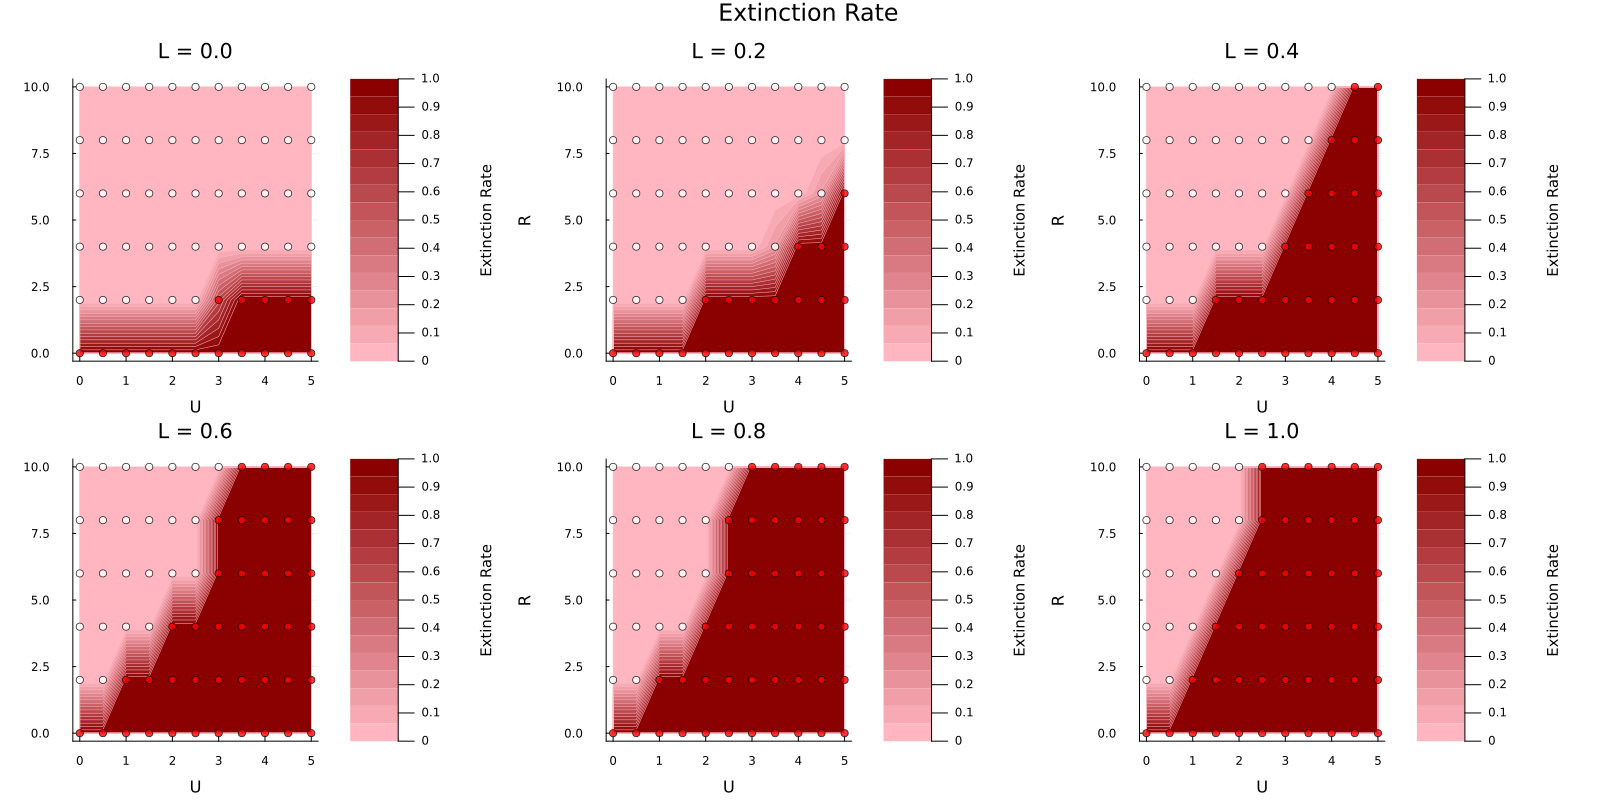

"/home/bio3dickib/LethalMutagenesis/production-model/scripts/parameter_sweep_results/extinction_rate_contours.png"

In [99]:
# Usage:
results = analyze_extinction_patterns("../scripts/parameter_sweep_results/master_results_extinctions.csv")
display(results.generation_plots)
display(results.extinction_rate_plots)

# Save the plots:
savefig(results.generation_plots, "../scripts/parameter_sweep_results/extinction_generation_contours.png")
savefig(results.extinction_rate_plots, "../scripts/parameter_sweep_results/extinction_rate_contours.png")

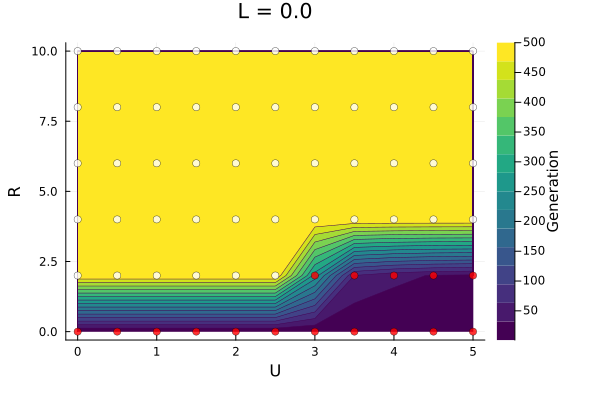

In [100]:
# For individual L values:
contour_data = prepare_contour_data("../scripts/parameter_sweep_results/master_results_extinctions.csv", 0.0)
p = create_contour_plot(contour_data, 0.0; plot_type=:extinction_generation)
display(p)

This suggests the further follow-up along the critical values and this can be achieved by running a refined parameter sweep in the same directory.

We need to recall that these sims are with the ΦX174 genome architecture. From `../scripts/run_parameter_sweep.jl`:
```
results = run_parameter_sweep_parallel("parameter_sweep_results", ΦX174_epi_config;
        num_reps=5,
        R_range=0:2:10,      # 6 values
        U_range=0:0.5:5.0,   # 11 values
        L_range=0.0:0.2:1.0) # 6 values
```

And this is the epistasis parameters:

In [101]:
print(ΦX174_epi_config)

EpistasisParams(Dict(:replication => 2, :assembly => 3, :host_interaction => 4, :auxiliary => 2), [:replication, :assembly, :host_interaction, :auxiliary], 11)

And the default simulation parameters:

In [102]:
sim_config

SimulationParams(500, -5.0, Poisson{Float64}(λ=5.0), 0.1, 5000, 10000, 9)

So this translates as:
>Control parameters

**sim_length::Int = 500**

**F_init::Float64 = -5.0**

>Sweep parameters

U_default::Poisson = Poisson(5.0) # but this is set/over-ridden in loop

L_default::Float64 = 0.1 # but this is set/over-ridden in loop

**N_default::Int = 5000**

**K_default::Int = 10000**

R_default::Int = 9 # but this is set/over-ridden in loop